# Boundary conditions

In [1]:
import numpy as np
import scipy as sp
import os
import sys
from scipy import optimize
from scipy import integrate
from scipy import interpolate
from matplotlib import pyplot as plt

## Import model

In [2]:
#current_dir = os.path.dirname(os.path.abspath(__file__))
#model_directory = os.path.join(current_dir, '..', 'cosmotransition_z2sb', 'cosmoTransitions')
model_directory='/Users/quarkquartet/Work/Wall-velocity/model/'
sys.path.append(model_directory)
import baseMo_s_b_d as bm

In [3]:
m = bm.model(702.654702269, -102.146250858, 0.112009439661, 0.0037322807528, -0.0370639674565,10000)

In [4]:
m.findAllTransitions()

Tracing phase starting at x = [246.00000051 572.58176356] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
...........................................................................................................................................................................
Tracing phase starting at x = [-2.27347289e-07  1.79312356e+02] ; t = 68.27354525855334
Tracing minimum down
traceMinimum t0 = 68.2735
..............................................................................
Tracing minimum up
traceMinimum t0 = 68.2735
..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[{'low_vev': array([202.04374412, 482.78409962]),
  'high_vev': array([9.51180104e-06, 1.78261369e+02]),
  'Tnuc': 61.79608446346483,
  'low_phase': 0,
  'high_phase': 1,
  'instanton': fullTunneling_rval(profile1D=Profile1D(R=array([0.00000000e+00, 1.04060051e-05, 1.88910615e-03, 3.76780630e-03,
         5.64650644e-03, 7.52520659e-03, 9.40390674e-03, 1.12826069e-02,
         1.31613070e-02, 1.50400072e-02, 1.69187073e-02, 1.87974075e-02,
         2.06761076e-02, 2.25548078e-02, 2.44335079e-02, 2.63122081e-02,
         2.81909082e-02, 3.00696083e-02, 3.19483085e-02, 3.38270086e-02,
         3.57057088e-02, 3.75844089e-02, 3.94631091e-02, 4.13418092e-02,
         4.32205094e-02, 4.50992095e-02, 4.69779097e-02, 4.88566098e-02,
         5.07353100e-02, 5.26140101e-02, 5.44927102e-02, 5.63714104e-02,
         5.82501105e-02, 6.01288107e-02, 6.20075108e-02, 6.38862110e-02,
         6.57649111e-02, 6.76436113e-02, 6.95223114e-02, 7.14010116e-02,
         7.32797117e-02, 7.51584118e-02, 7.70

In [5]:
m.TnTrans[0].keys()

dict_keys(['low_vev', 'high_vev', 'Tnuc', 'low_phase', 'high_phase', 'instanton', 'action', 'trantype', 'crit_trans', 'rho+', 'rho-', 'p+', 'p-', 'ep+', 'ep-'])

In [6]:
hv = m.TnTrans[0]['high_vev']
lv = m.TnTrans[0]['low_vev']
Tnuc = m.TnTrans[0]['Tnuc']
Vtot = m.Vtot

## Thermodynamic quantities

In [7]:
def derivative(f, x, eps=1e-5, order=1):
    """Calculate the derivative of a function.
    Using Ridders algorithm.
    Calculate up to order x**4.
    Only compute 1st or 2nd order derivative."""
    assert (
        order == 1 or order == 2
    ), "Calculate derivative up to an order, must be 1 or 2."
    δx = x * eps
    if order == 1:
        return (f(x - 2 * δx) - 8 * f(x - δx) + 8 * f(x + δx) - f(x + 2 * δx)) / (
            12 * δx
        )
    if order == 2:
        return (f(x - 2 * δx) - f(x - δx) - f(x + δx) + f(x + 2 * δx)) / (3 * δx**2)

In [27]:
def cs_sq(V,T, vev):
    """Sound speed square."""
    v = optimize.fmin(V, vev, args=(T,), disp=0)
    def VT(T):
        return V(v,T)
    return derivative(VT, T, order=1)/(T*derivative(VT, T, order=2))

In [9]:
cs_sq(Vtot, Tnuc, hv)

0.33379900900581405

In [10]:
cs_sq(Vtot, Tnuc,lv)

0.29347226243359037

In [28]:
def epsilon(V,T,vev):
    """Epsilon."""
    v = optimize.fmin(V, vev, args=(T,), disp=0)
    def VT(T):
        return V(v,T)
    return - 0.25*T*derivative(VT,T) + VT(T)

def a(V,T, vev):
    """The parameter a, means the effective dofs."""
    v = optimize.fmin(V, vev, args=(T,), disp=0)
    def VT(T):
        return V(v,T)
    return - 0.75 * derivative(VT,T)/T**3


def alpha_p(V, Tp, Tm, high_vev, low_vev):
    return (epsilon(V,Tp,high_vev) - epsilon(V,Tm, low_vev))/(a(V,Tp, high_vev) * Tp**4)

def r_func(V,Tp,Tm, high_vev, low_vev):
    return a(V,Tp, high_vev)*Tp**4/(a(V,Tm, low_vev)*Tm**4)

def w(V, T, vev):
    v = optimize.fmin(V, vev, args=(T,), disp=0)
    def VT(T):
        return V(v, T)
    return - T * derivative(VT,T)

## Solve detonation

In [13]:
def match(vp,vm,Tp,Tm, high_vev, low_vev):
    r = r_func(Vtot, Tp, Tm, high_vev, low_vev)
    αp = alpha_p(Vtot, Tp, Tm, high_vev, low_vev)
    vpvm = 1-(1-3*αp)*r
    vpvm = vpvm/(3-3*(1+αp)*r)
    ratio = 3 + (1-3*αp)*r
    ratio = ratio/(1+3*(1+αp)*r)
    return [vp*vm - vpvm, vp/vm - ratio]

In [16]:
match(0.7,0.5,61.8, 61.0, hv,lv)

[0.37488767629163944, 0.676399039862079]

In [10]:
def guess_det(vp, Tp, ap, am, εp, εm):
    αp = (εp-εm)/(ap*Tp**4)
    r=1/(1+3*αp)
    Tm = (ap*Tp**4/(am*r))**0.25
    vpvm = 1-(1-3*αp)*r
    vpvm = vpvm/(3-3*(1+αp)*r)
    vm = min(vpvm/vp, 0.67)
    return [vm,Tm]

In [11]:
def vJ(alphap):
    v = (alphap*(2+3*alphap))**0.5 + 1
    v = v/((1+alphap)*3**0.5)
    return v

In [61]:
vJ(0.091)

0.769870894800983

In [24]:
vJ(0.050858596835864606)

0.7311924971667051

In [70]:
vw=0.9
guess = guess_det(vw, m.TnTrans[0]['Tnuc'],a(m.Vtot,  m.TnTrans[0]['Tnuc'], m.TnTrans[0]['high_vev']), a(m.Vtot,m.TnTrans[0]['Tnuc']*1.1,m.TnTrans[0]['low_vev']),epsilon(m.Vtot, m.TnTrans[0]['Tnuc'], m.TnTrans[0]['high_vev']), epsilon(m.Vtot, m.TnTrans[0]['Tnuc'], m.TnTrans[0]['low_vev']))
sol=optimize.fsolve(lambda x:match(vw, x[0], m.TnTrans[0]['Tnuc'], x[1], m.TnTrans[0]['high_vev'], m.TnTrans[0]['low_vev']),guess, xtol=1e-10)
print(sol)

[ 0.87038531 69.71010894]


In [71]:
vJ(alpha_p(Vtot, Tnuc,sol[1], hv, lv ))

0.761388175868889

In [12]:
def μ(x, v):
    return (x-v)/(1-x*v)

def dYda(tau, y, *args):
    """Y: (v, xi, T)"""
    v = y[0]
    xi = y[2]
    T = y[1]
    V=args[0]
    vev=args[1]
    dvdtau = 2 * v * cs_sq(V, T, vev) * (1-v**2) * (1- xi * v)
    dxidtau = xi *((xi-v)**2 - cs_sq(V,T,vev) * (1-xi*v)**2)
    dvdxi = 2*v/xi * (1-v**2)
    dvdxi = dvdxi/(1-v*xi)/(μ(xi, v)**2/cs_sq(V,T,vev) - 1)
    dTdxi = T * μ(xi, v) * dvdxi / (1-v**2)
    dTdtau = dTdxi * dxidtau
    return np.array([dvdtau, dTdtau, dxidtau])


In [95]:
vsol=integrate.solve_ivp(dYda, (10,0.1), np.array([μ(vw, sol[0]), sol[1], vw]),t_eval=np.linspace(10,0.1,1000),method='DOP853', args=(Vtot,lv))

Text(0.5, 1.0, 'Detonation, $v_w = 0.9$')

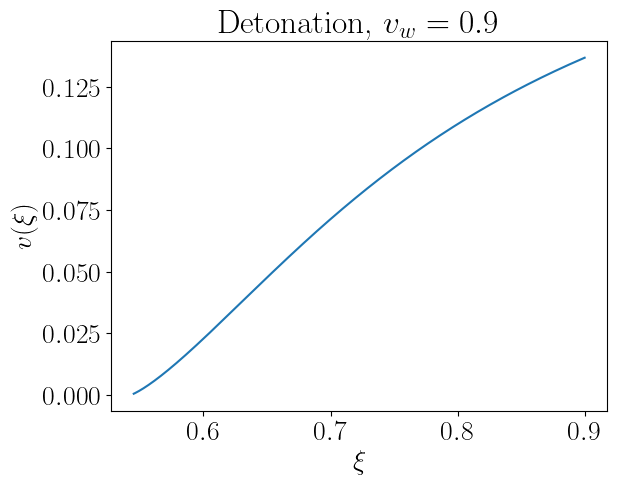

In [99]:
plt.plot(vsol.y[2],vsol.y[0])
plt.xlabel(r'$\xi$')
plt.ylabel(r'$v(\xi)$')
plt.title(r'Detonation, $v_w = 0.9$')

## Solve deflagration

Try to solve the deflagration solution with vw = 0.5

In [14]:
vw = 0.5
Tm = 60
guess_sol= optimize.fsolve(lambda x:match(x[0],vw,x[1], Tm, hv, lv),[0.1, Tnuc], xtol=1e-10)
print(guess_sol)

[ 0.31077114 66.30557572]


In [29]:
def dYda(tau, y, *args):
    """Y: (v, xi, T)"""
    v = y[0]
    xi = y[2]
    T = y[1]
    V=args[0]
    vev=args[1]
    dvdtau = 2 * v * cs_sq(V, T, vev) * (1-v**2) * (1- xi * v)
    dxidtau = xi *((xi-v)**2 - cs_sq(V,T,vev) * (1-xi*v)**2)
    dvdxi = 2*v/xi * (1-v**2)
    dvdxi = dvdxi/(1-v*xi)/(μ(xi, v)**2/cs_sq(V,T,vev) - 1)
    dTdxi = T * μ(xi, v) * dvdxi / (1-v**2)
    dTdtau = dTdxi * dxidtau
    return np.array([dvdtau, dTdtau, dxidtau])

def μ(x, v):
    return (x-v)/(1-x*v)


In [30]:
def dvTdxi(xi, y, *args):
    v = y[0]
    T = y[1]
    V = args[0]
    vev = args[1]
    dvdxi = 2*v/xi * (1-v**2)
    dvdxi = dvdxi/(1-v*xi)/(μ(xi, v)**2/cs_sq(V,T,vev) - 1)
    dTdxi = T * μ(xi, v) * dvdxi / (1-v**2)
    return np.array([dvdxi, dTdxi])

In [31]:
vsol=integrate.solve_ivp(dYda, (10,1), np.array([μ(vw, guess_sol[0]), guess_sol[1], vw]),t_eval=np.linspace(10,1,1000),method='DOP853', args=(Vtot,hv))

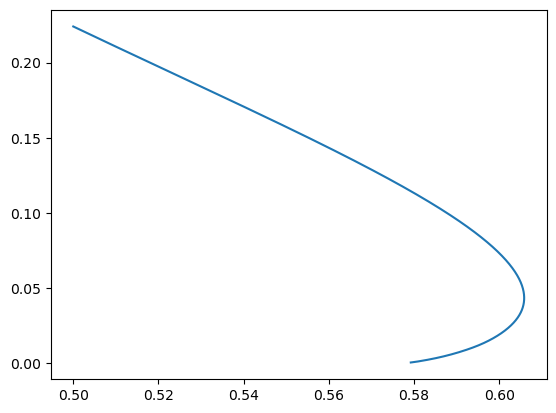

In [32]:
plt.plot(vsol.y[2],vsol.y[0])

In [33]:
xi_max = vsol.y[2].max()
xi_max_index = vsol.y[2].argmax()
v_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1], vsol.y[0][0:xi_max_index+1], kind='cubic')
T_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1], vsol.y[1][0:xi_max_index+1], kind='cubic')

In [29]:
xi_max

0.605831301288266

In [46]:
vsol.t[xi_max_index]

7.342342342342342

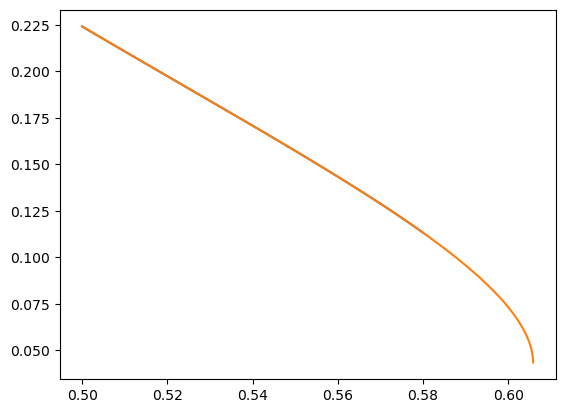

In [34]:
xplot = np.linspace(0.5, 0.58, 100)
vplot = [v_prof(x) for x in xplot]
plt.plot(xplot, vplot)
plt.plot(vsol.y[2][0:xi_max_index+1],vsol.y[0][0:xi_max_index+1])

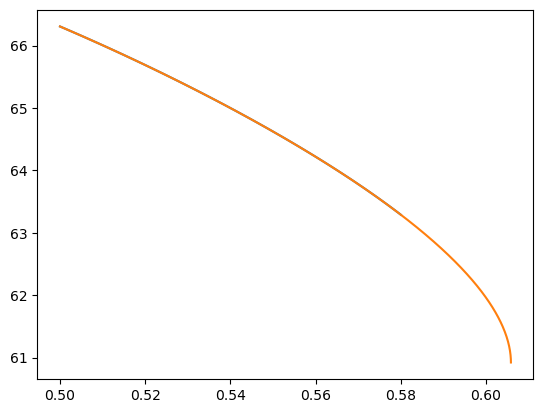

In [35]:
xplot = np.linspace(0.5, 0.58, 100)
Tplot = [T_prof(x) for x in xplot]
plt.plot(xplot, Tplot)
plt.plot(vsol.y[2][0:xi_max_index+1], vsol.y[1][0:xi_max_index+1])

In [36]:
xsh=optimize.brentq(lambda x: μ(x, v_prof(x))*x - cs_sq(Vtot, T_prof(x), hv), 0.5, xi_max*0.999)
xsh

0.6013263119430584

In [37]:
T_prof(xsh)

array(61.82332245)

In [38]:
def find_Tsh(Tm):
    guess_sol = optimize.fsolve(lambda x:match(x[0], 0.5, x[1], Tm,hv, lv),[0.1,Tnuc])
    try:
        vsol=integrate.solve_ivp(dYda, (10,0.01), np.array([μ(0.5, guess_sol[0]), guess_sol[1], 0.5]),t_eval=np.linspace(10,0.01,1000),method='DOP853',args=(Vtot, hv))
        xi_max = vsol.y[2].max()
        xi_max_index = vsol.y[2].argmax()
        v_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1],vsol.y[0][0:xi_max_index+1])
        T_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1],vsol.y[1][0:xi_max_index+1])
        xsh=optimize.brentq(lambda x: μ(x, v_prof(x))*x - cs_sq(Vtot, T_prof(x), hv), 0.5, xi_max*0.9999)
    except:
        vTsol = integrate.solve_ivp(dvTdxi, (vw, 1), np.array([μ(vw, guess_sol[0]), guess_sol[1]]), t_eval=np.linspace(vw, 1, 500), method='DOP853', args=(Vtot, hv))
        v_prof = interpolate.interp1d(vTsol.t, vTsol.y[0], kind='cubic')
        T_prof = interpolate.interp1d(vTsol.t, vTsol.y[1], kind='cubic')
        xsh = optimize.brentq(lambda x: μ(x, v_prof(x))*x - cs_sq(Vtot, T_prof(x), hv), vw, 1)
    return T_prof(xsh)

In [39]:
find_Tsh(55)

array(58.34035977)

In [25]:
Tmax = m.TnTrans[0]['Tnuc']
Tmin = 58
for i in range(30):
    Tcal=(Tmax+Tmin)/2
    Tsh = find_Tsh(Tcal)
    if Tsh < m.TnTrans[0]['Tnuc']:
        Tmin = Tcal
    else:
        Tmax = Tcal

In [26]:
Tcal

59.962963788577525

In [54]:
find_Tsh(Tcal)

array(61.79611433)

In [55]:
Tm = Tcal
vp, Tp = optimize.fsolve(lambda x:match(x[0],0.5,x[1], Tcal, hv, lv),[0.3, Tnuc], xtol=1e-10)
print(vp, Tp)

0.31047522910630265 66.27942104354211


In [56]:
print(lv, hv)

[202.04374412 482.78409962] [9.51180104e-06 1.78261369e+02]


In [59]:
vsol=integrate.solve_ivp(dYda, (10,0.01), np.array([μ(0.5, vp), Tp, 0.5]),t_eval=np.linspace(10,0.01,1000),method='DOP853',args=(Vtot, hv))
xi_max = vsol.y[2].max()
xi_max_index = vsol.y[2].argmax()
v_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1],vsol.y[0][0:xi_max_index+1])
T_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1],vsol.y[1][0:xi_max_index+1])

Text(0.5, 1.0, 'Deflagration, $v_w = 0.5$, $T_n = 61.79$ GeV')

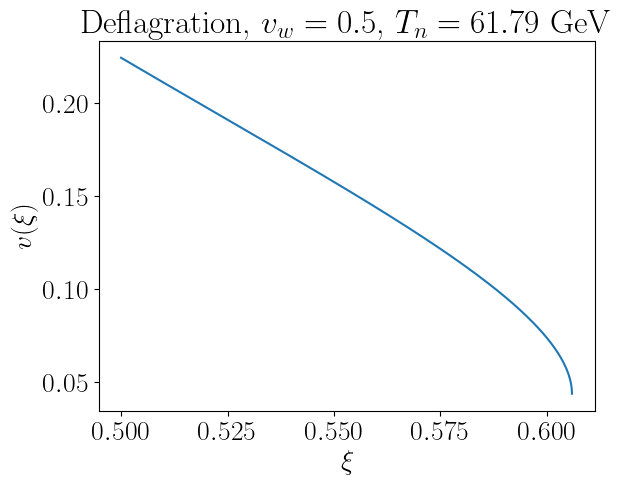

In [60]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size='20')
plt.rc('text.latex', preamble=r'\usepackage{wasysym}')
plt.plot(vsol.y[2][0:xi_max_index+1],vsol.y[0][0:xi_max_index+1])
plt.xlabel(r'$\xi$')
plt.ylabel(r'$v(\xi)$')
plt.title(r'Deflagration, $v_w = 0.5$, $T_n = 61.79$ GeV')

Text(0.5, 1.0, 'Deflagration, $v_w = 0.5$, $T_n = 61.79$ GeV')

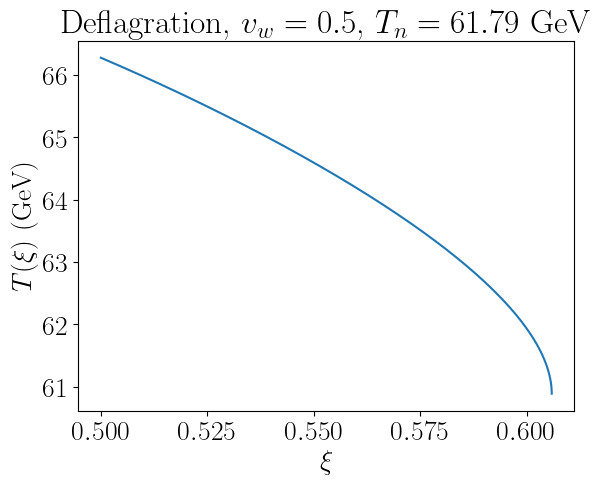

In [61]:
plt.plot(vsol.y[2][0:xi_max_index+1],vsol.y[1][0:xi_max_index+1])
plt.xlabel(r'$\xi$')
plt.ylabel(r'$T(\xi)$ (GeV)')
plt.title(r'Deflagration, $v_w = 0.5$, $T_n = 61.79$ GeV')

## Solve the temperature profile

In [62]:
h0 = lv[0]
s0 = lv[1]-hv[1]
s_initial=hv[1]
def h_profile(z,Lh):
    z = np.asanyarray(z)
    hz = 0.5*h0*(1-np.tanh(z/Lh))
    return hz

def s_profile(z, Ls, deltas):
    z = np.asanyarray(z)
    sz = 0.5*s0*(1-np.tanh(z/Ls + deltas)) + s_initial
    return sz

c1 = w(Vtot, Tp, hv) * vp/(1-vp**2)
s1=c1
c2=-Vtot(hv, Tp)+ w(Vtot, Tp, hv) * vp**2 /(1-vp**2)
s2=c2

def T33(T,z, Lh, Ls, deltas):
    derh = derivative(lambda zvalue: h_profile(zvalue,Lh),z)
    ders = derivative(lambda zvalue: s_profile(zvalue,Ls,deltas),z)
    field_value = [h_profile(z, Lh), s_profile(z, Ls, deltas)]
    return (0.5*(derh**2 + ders**2) - Vtot(field_value, T) - 0.5*w(Vtot, T, field_value) + 0.5*(4*s1**2 + w(Vtot, T, field_value)**2)**0.5 - s2)/1e6

In [63]:
optimize.newton(lambda T: T33(T, 0.1, 1.0, 1.0, 0.3), 60)

65.89698099617532

In [104]:
Lh = 0.01
Ls = 0.01
deltas = 0.0
npoints =100
z_range = np.linspace(-10*max(Lh,Ls), 10*max(Lh,Ls), npoints)
T_sol = np.zeros((npoints,))
for i in range(npoints):
    T33min = optimize.minimize(lambda T: T33(T[0], z_range[i], Lh, Ls, deltas), Tnuc, method='Nelder-Mead', bounds=[(40,90)])
    if T33min.fun > 0:
        T_sol[i]=T33min.x[0]
    else:
        try:
            s = optimize.newton(lambda T: T33(T, z_range[i], Lh, Ls, deltas), Tnuc)
        except:
            s = optimize.fsolve(lambda T: T33(T[0], z_range[i], Lh, Ls, deltas), Tnuc)[0]
        T_sol[i] = s

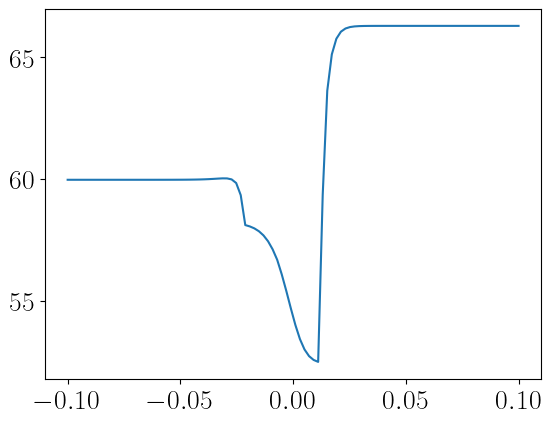

In [105]:
plt.plot(z_range, T_sol)

In [79]:
T_sol[0]

59.96296390590981

In [76]:
Tm

59.962963788577525